<img src="https://raw.githubusercontent.com/sstober/openmiir/master/logo/OpenMIIR-logo_transparent_728x265.png" width=400 />

<br><br><br>
<center>
<font size="+6"><b>Group 3 Project</b></font><br><br>
<font size="+2"><b>Music Imagery Information Retrieval</b></font><br>
</center>

<br>

- Students: *Elias Düker, Leon Grund, Jakob Prager, Veronika Pressler*
- Course: *Neuroinformatics: Machine Learning for Neuronal Data Analysis (2022W)*
- Deadline: *January 26, 2023*

<br>

**Abstract summary.**

In this project, we aim to gain insights into the nascent study of music imagery information retrieval (MIIR). This field studies the brain's perception of music through the analysis of EEG data gained while a subject was listening to or imagining music. The dataset contains 10 participants, 12 audio stimuli, 4 conditions and 5 blocks, which gives 2'400 trials (~6.5 GB of data) in total.

<br>

**Table of contents.**
1. [Raw data](#data)
2. [Preprocessing](#preprocessing)
3. [Methods](#methods)
4. [Results](#results)<br>
    <small>4.1 [Predict Conditions](#results1)<br>
    4.2 [Predict Song Groups](#results2)<br>
    4.3 [Predict Songs](#results3)<br>
    </small>
5. [Appendix](#appendix)
6. [References](#references)

<br>

**Dataset.**

`OpenMIIR RawEEG v1.0` <sub>Source: http://bmi.ssc.uwo.ca/OpenMIIR-RawEEG_v1/</sub>


<br>

**Libraries.**
- `numpy`: v1.18.5
- `matplotlib`: v3.2.2
- `seaborn`: v0.10.1
- `mne`: v1.2.3
- `sklearn`: v0.23.1
- `pyriemann`: v0.3

<br>

**Requirements.**

Please make sure that the `P01-raw.fif` file<sup>1</sup> can be found in a folder `data` in the same directory as this notebook, i.e.
```
project/
│   readme.md
│   this_notebook.ipynb
│
└───data/
        P01-raw.fif
```

<sub><sup>1</sup>You can download all raw files here: http://bmi.ssc.uwo.ca/OpenMIIR-RawEEG_v1/.</sub>

In [11]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
%matplotlib inline

# mne
import mne
from mne.preprocessing import ICA, read_ica
from mne.decoding import CSP, UnsupervisedSpatialFilter

# sklearn
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

# pyriemann
import pyriemann
from pyriemann.classification import MDM
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

In [12]:
print('python:', sys.version.split()[0])
print('numpy:', np.__version__)
print('matplotlib:', matplotlib.__version__)
print('seaborn:', sns.__version__)
print('mne:', mne.__version__)
print('sklearn:', sklearn.__version__)
print('pyriemann:', pyriemann.__version__)

python: 3.8.3
numpy: 1.18.5
matplotlib: 3.2.2
seaborn: 0.10.1
mne: 1.2.3
sklearn: 0.23.1
pyriemann: 0.3


<a id="data"></a>
# 1. Raw data

Below we show an example how to load and illustrate the raw EEG data for subject `P01`. If you have downloaded further raw files of other participants, you can also change the `subject` to investigate the differences.

In [13]:
subject = 'P01'  # 'P01','P04','P05','P06','P07','P09','P10','P11','P12','P13','P14'
raw = mne.io.read_raw_fif(f'data/{subject}-raw.fif', verbose=0)
raw.info

<Info | 11 non-empty values
 bads: 3 items (P8, P10, T8)
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 4 EOG, 1 Stimulus
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2015-01-28 17:39:57 UTC
 meas_id: 4 items (dict)
 nchan: 69
 projs: Average EEG reference: off
 sfreq: 512.0 Hz
>

Please note that the EEG channel positions in the topomap below are slightly inaccurate, since we are using the `standard_1020` montage to improve readability of our code. The dataset authors wrote their custom montage class, see `Biosemi64Layout(ChannelLayout)` in [[1]](#bib_github), which is a few hundred lines of code.

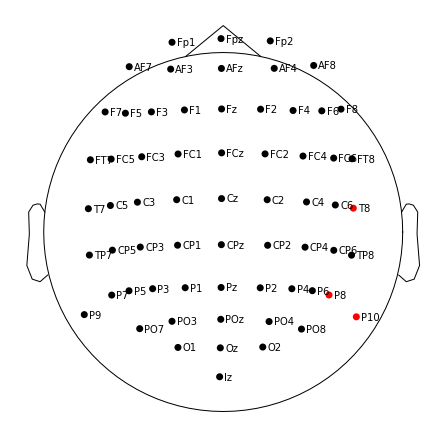

In [14]:
# set montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, on_missing='ignore')

# plot topomap of sensors
raw.plot_sensors(kind='topomap', show_names=True, to_sphere=True);

In the following cell you can investigate the signals in the raw dataset.

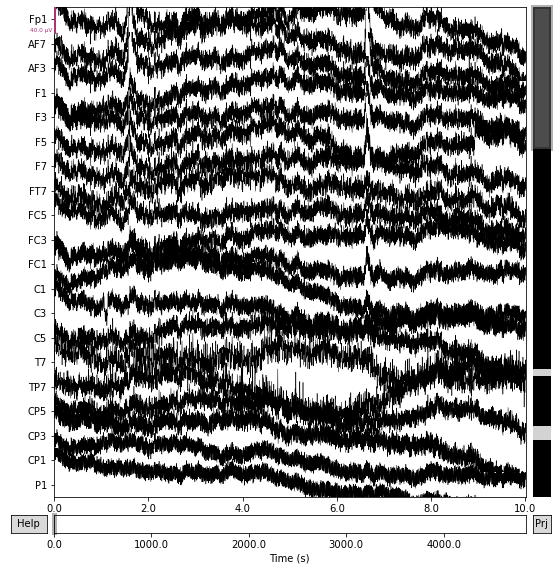

In [15]:
raw.plot();

Moreover, the charts below illustrate the averaged signals for participant 1 and song 1 for different conditions. These charts provide a first indication whether we can visually detect differences between perception and imaginiation (with and without cue clicks).

Removing projector <Projection | Average EEG reference, active : True, n_channels : 64>
No projector specified for this dataset. Please consider the method self.add_proj.


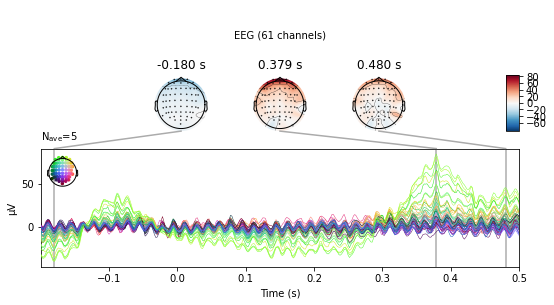

Removing projector <Projection | Average EEG reference, active : True, n_channels : 64>
No projector specified for this dataset. Please consider the method self.add_proj.


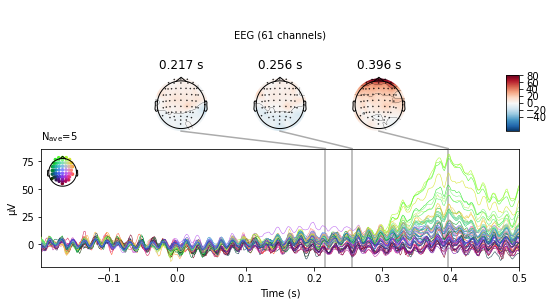

Removing projector <Projection | Average EEG reference, active : True, n_channels : 64>
No projector specified for this dataset. Please consider the method self.add_proj.


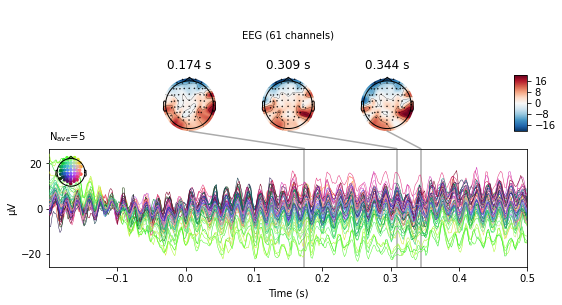

Removing projector <Projection | Average EEG reference, active : True, n_channels : 64>
No projector specified for this dataset. Please consider the method self.add_proj.


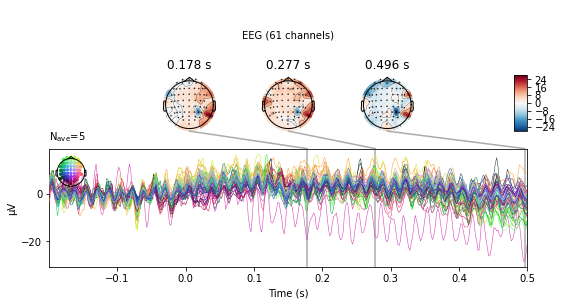

In [16]:
events = mne.find_events(raw, stim_channel='STI 014', verbose=0)

for condition in [1, 2, 3, 4]:
    event = f'1{condition}'
    fig = mne.Epochs(raw, events=events, verbose=0)[event].average().plot_joint();

The event markers recorded in the raw EEG comprise:
- Trial labels (as a concatenation of stimulus ID and condition) at the beginning of each trial
- Exact audio onsets for the first cue click of each trial in conditions 1 and 2 (detected by the Stimtracker)
- Subject feedback for the condition 4 trials (separate event IDs for positive and negative feedback)

For example, the event "imagining Chim Chim Cheree with lyrics and cue clicks" would be `12`, since
- songs with lyrics belong the the `0`th group
- Chim Chim Cheree is the `1`st song in the group
- imagining with cue clicks is condition `2`.

The function `mne.viz.plot_events()` provides a great overview of all different events in this dataset. It shows that songs are picked in random order (i.e. first song was `12`, then song `3`, and so on), and the conditions `1`, `2` and `3` are recorded subsequentially. In a separate session, we can then find all songs under condition `4`, followed by the "feedback-event" `2000` or `2001`.

<ipython-input-17-cd8e0d42c5ee>:4: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(trial_events, raw.info['sfreq'], raw.first_samp, axes=axes)


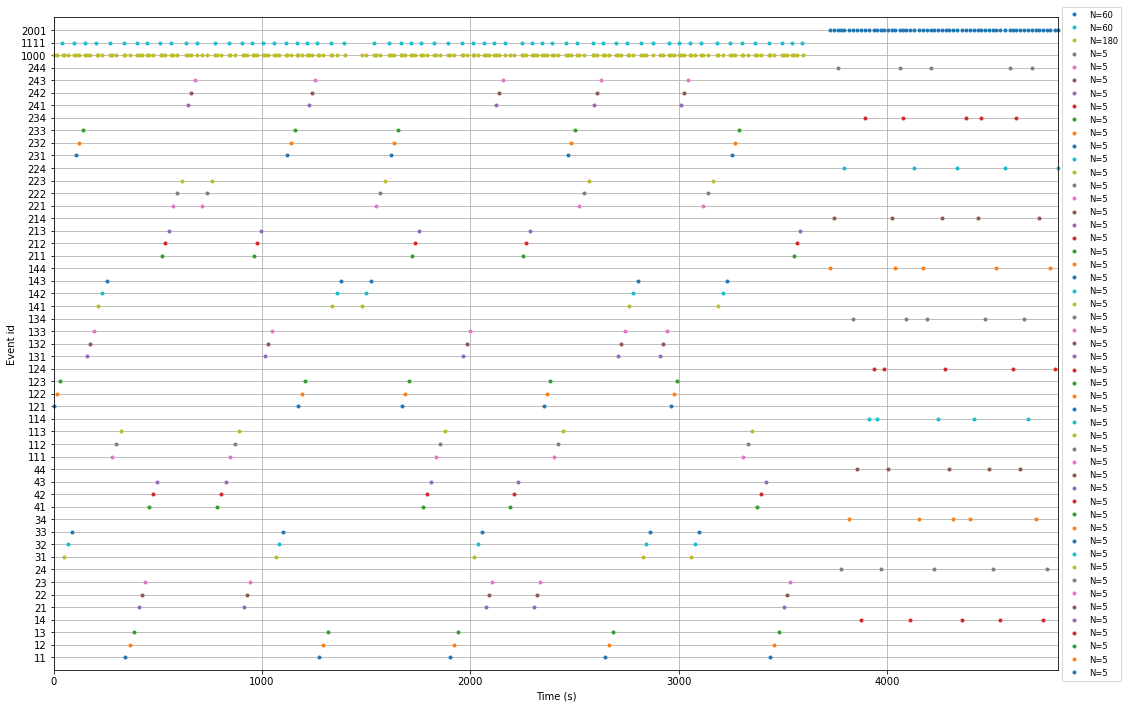

In [17]:
plt.figure(figsize=(20, 12))
axes = plt.gca()
trial_events = mne.find_events(raw, stim_channel='STI 014', verbose=0)
fig = mne.viz.plot_events(trial_events, raw.info['sfreq'], raw.first_samp, axes=axes)

<a id="preprocessing"></a>
# 2. Preprocessing

The function `store_preprocessed_data` takes care of all our preprocessing steps:
1. load dataset,
2. remove ambiguous<sup>2</sup> channels,
3. interpolate bad channels,
4. apply bandpass-filtering,
5. downsample,
6. averaging,
7. chunk, shift and create epochs,
7. save preprocessed dataset.

We have tried many different preprocessing pipelines, e.g. applying ICA or removing highly correlated components with EOG channels, which did not improve our results. We also tried to use different band-pass filters or epoch lengths and shifts. Below, we used the same settings as for our presentation.

As the name says, the `store_preprocessed_data` function stores the results as `npy` files in the `data` folder (same location as the `fif` file). The reason is that we also worked with multiple files (not only `P01-raw.fif`) which often caused a memory overload. By storing the results we were able to process all 6.5 GB of data and also speed up the code in the results section.

--- 
<sub><sup>2</sup> Ambiguous channels are channels like `EXG5` and `EXG6`, which are marked as EEG, but only present for 5 out of 10 participants. Moreover, these additional channels have no positional information, causing the `set_montage` function to fail. We decided to remove these extra channels.

In [18]:
def store_preprocessed_data():
    
    # collect all raw files
    raw_files = [f for f in os.listdir('data') if '-raw.fif' in f]
    
    for filename in raw_files:
        
        # preload data
        data = mne.io.read_raw_fif(f'data/{filename}', preload=True, verbose=0)

        # remove ambiguous channels (e.g. 'EXG5', 'EXG6', ...)
        ch_names = data.info['ch_names']
        ch_types = data.get_channel_types()
        drop_channels = []
        for name, typ in zip(ch_names, ch_types):
            if name.startswith('EXG') and typ == 'eeg':
                drop_channels.append(name)
        data.drop_channels(ch_names=drop_channels)

        # set montage
        montage = mne.channels.make_standard_montage('standard_1020')
        data.set_montage(montage, on_missing='ignore', verbose=0)

        # interpolate bad channels
        data.interpolate_bads(reset_bads=True, verbose=0)

        # apply bandpass-filtering between 1 and 40 Hz
        data.filter(l_freq=1., h_freq=40., verbose=0)

        # downsampling to 64 Hz
        data.resample(64., npad='auto', verbose=0)

        # averaging
        data.set_eeg_reference(ref_channels='average', verbose=0)

        # chunk data by events
        events = mne.find_events(data, shortest_event=1, stim_channel='STI 014', verbose=0)
        
        # shift time 3 seconds (in order to ignore cue clicks)
        events = mne.event.shift_time_events(events, ids=list(set(events[:, 2])), tshift=3, sfreq=raw.info['sfreq'])
        
        # split data into 2 second epochs for each event
        epochs = mne.Epochs(data, events=events, picks='eeg', tmin=-0.1, tmax=2., verbose=0)
        
        # get data and events
        x = epochs.get_data()
        y = epochs.events[:, 2]

        # combine previous event and 1000 events, e.g. if y=[121,1000,122,1000] then y_new=[121,1121,122,1122] (can be ignored)
        # y = np.where(y == 1000, 1000 + np.roll(y, shift=1), y)
        
        # save data and labels in .npy file per subject
        filename_out = filename.replace('raw.fif', 'preprocessed.npy')
        with open(f'data/{filename_out}', 'wb') as f:
            np.save(f, x)
            np.save(f, y)

    return None

The following cell will execute all preprocessing steps and store the files within the `data` folder.<sup>3</sup> Loading all the data into memory (~6.5 GB) did not work on our machines, so we had to store the preprocessed data as well.

<font color="red"><b>Runtime:</b> approx. 20 seconds for `P01-raw.fif` (or 3 minutes for all 10 files).</font>

--- 
<sub><sup>3</sup> Note that we are using the `%%capture --no-display` cell magic command to keep the cell output clean. Comment the line out, if you want to see the `mne` information messages for each preprocessing step and file.</sub>



In [10]:
%%capture --no-display

# store preprocessed data for each participant
store_preprocessed_data()

In [19]:
def load_preprocessed_data(subjects=None, event_encodings=None):
    xs, ys = [], []
    
    if not subjects:
        subjects = ['P01','P04','P05','P06','P07','P09','P11','P12','P13','P14']
    
    for subject in subjects:

        # load preprocessed data
        with open(f'data/{subject}-preprocessed.npy', 'rb') as f:
            x = np.load(f)
            y = np.load(f)
        
        # translate events into class labels
        if event_encodings:
            y = np.array([event_encodings.get(e) for e in y]).copy()

            # find indices for mapped labels
            labels = list(set(event_encodings.values()))
            idx = np.where(np.isin(y, labels))
        else:
            idx = np.where(y == y)
            
        # append labelled data
        xs.append(x[idx].copy())
        ys.append(y[idx].copy())
        
        # delete x, y
        del x, y
        
    return np.concatenate(xs), np.concatenate(ys)

<a id="methods"></a>
# 3. Methods

We implemented many different models and performed many hours of hyperparameter tuning. However, to make it easier for you to review and reproduce our results, we only added four different models below:

- `svc()` uses PCA, CSP, StandardScaler and a support vector machine classifier.
- `lda()` uses PCA, CSP, StandardScaler and a linear discriminant analysis classifier.
- `tangentspace()` uses the Riemann metric as shown in the lecture with a support vector machine classifier.
- `mdm()` uses the minimum distance to mean classification.

We also kept our `custom()` gridsearch-pipepline in the cell below but commented it out to improve runtime for review and grading. This is just to show that we also tried to improve the model parameters in each pipeline.

In [34]:
def svc(X_train, y_train):
    clf = Pipeline(steps=[
        ("PCA", UnsupervisedSpatialFilter(PCA(10), average=False)),
        ("CSP", CSP(n_components=10, reg='ledoit_wolf', log=True)),
        ("scaler", StandardScaler()),
        ("model", SVC())
    ])
    clf.fit(X_train, y_train)
    return clf


def lda(X_train, y_train):
    clf = Pipeline(steps=[
        ("PCA", UnsupervisedSpatialFilter(PCA(10), average=False)),
        ("CSP", CSP(n_components=10, reg='ledoit_wolf', log=True)),
        ("scaler", StandardScaler()),
        ("model", LinearDiscriminantAnalysis())
    ])
    clf.fit(X_train, y_train)
    return clf


def tangentspace(X_train, y_train):
    clf = Pipeline(steps=[
        ('cov', Covariances("oas")), 
        ('tangentspace', TangentSpace(metric="riemann")), 
        ('classifier', SVC())
        ])
    clf.fit(X_train, y_train)
    return clf


def mdm(X_train, y_train):
    clf = Pipeline(steps=[
        ('cov', Covariances("oas")), 
        ('class', MDM(metric="riemann", n_jobs = -1))
        ])
    clf.fit(X_train, y_train)
    return clf

In the model developement phase, we also applied `GridSearchCV` in order to find the best settings of each pipeline. However, this drastically increases the runtime of the notebook and we only presented you the final models with best parameters above.

In [21]:
# def custom(X_train, y_train):
#     clf = Pipeline(steps=[
#         ("PCA", UnsupervisedSpatialFilter(PCA(20), average=False)),
#         ("CSP", CSP(n_components=20, reg='ledoit_wolf', log=True)),
#         ("scaler", StandardScaler()),
#         ("classify", SVC())
#     ])
#     params = {'classify__kernel':('linear', 'poly'), 'classify__C' : [0.01, 0.1, 1, 10]} 
#     grid = GridSearchCV(clf, params)
#     grid.fit(X_train, y_train)
#     return grid

The `run_pipeline` function performs 10-fold cross-validation for each pipeline model and returns the accuracies and confusion matrices. Furthermore, by setting `plot=True`, two charts will be produced showing the model performances (in terms of accuracy) as well as best models' confusion matrix.

In [59]:
def run_pipeline(subjects, event_encodings, plot=False, postfix=''):
    
    X_all, y_all = load_preprocessed_data(subjects=subjects, event_encodings=event_encodings)
    
    split_obj = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    acc, cm = {}, {}
    
    for train_func in [svc, lda, tangentspace, mdm]:
        acc_per_func = []
        cm_per_func = []
    
        for train_index, test_index in split_obj.split(X_all, y_all):
            # get train-test split
            X_train, X_test = X_all[train_index], X_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]

            # train classifier
            clf = train_func(X_train, y_train)

            # predict labels
            y_pred = clf.predict(X_test)

            # append accuracy for this fold
            acc_per_func.append(accuracy_score(y_test, y_pred))

            # append confusion matrix for this fold    
            cm_labels = np.unique(y_test)
            cm_array = confusion_matrix(y_test, y_pred)
            cm_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
            cm_per_func.append(cm_df)
        
        acc.update({train_func.__name__: acc_per_func})
        cm.update({train_func.__name__: cm_per_func})
    
    # plot mean accuracy of all models and best models' confusion matrix
    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

        # model accuracy comparison
        df = pd.melt(pd.DataFrame(acc)).rename(columns={'variable': 'model'})
        sns.barplot(x=df.model, y=df.value, palette="Oranges", ax=ax1)
        ax1.set_title(f'Accuracy {postfix}')

        # confusion matrix (best model only)
        best_model = pd.DataFrame(acc).mean().idxmax(axis=0)
        sns.heatmap(sum(cm.get(best_model)) / np.sum(sum(cm.get(best_model)), axis=1), annot=True, cmap='Oranges', annot_kws={"size": 12}, ax=ax2)
        ax2.set_title(f'Confusion matrix {postfix} ({best_model})')
        plt.yticks(rotation=0)
        # fig.savefig(f'results/confusion_matrix-predict_conditions.png')
        fig.tight_layout()
        plt.show();
    
    del X_all, y_all
    
    return acc, cm

<a id="results"></a>
# 4. Results

Below we illustrate our results from three experiments:

    1) Predicting the correct condition
    2) Predict the correct song group
    3) Predict the correct song

In each case, we created a dictionary mapping the event codes to the respective classes, i.e. `11` $\to$ `perception`, `12` $\to$ `imagination with cue`, etc. We plot the average $k$-fold cross-validated test accuracy for each model as barplots and the best performing models results as confusion matrix.

In [23]:
GROUPS = [0, 1, 2]
SONGS = [1, 2, 3, 4]
CONDS = [1, 2, 3, 4]

<a id="results1"></a>
### 4.1 Predict Conditions

In [24]:
# perception vs imagination with cue (balanced)
class1 = [int(f'{g}{s}{c}') for g in GROUPS for s in SONGS for c in [1]]
class2 = [int(f'{g}{s}{c}') for g in GROUPS for s in SONGS for c in [2]]
class3 = [int(f'{g}{s}{c}') for g in GROUPS for s in SONGS for c in [3]]
class4 = [int(f'{g}{s}{c}') for g in GROUPS for s in SONGS for c in [4]]

mapping1 = {}
mapping1.update({event_id: 'c1: perception' for event_id in class1})
mapping1.update({event_id: 'c2: imagination' for event_id in class2})
mapping1.update({event_id: 'c3: imagination w/o cue' for event_id in class3})
mapping1.update({event_id: 'c4: imagination feedback' for event_id in class4})

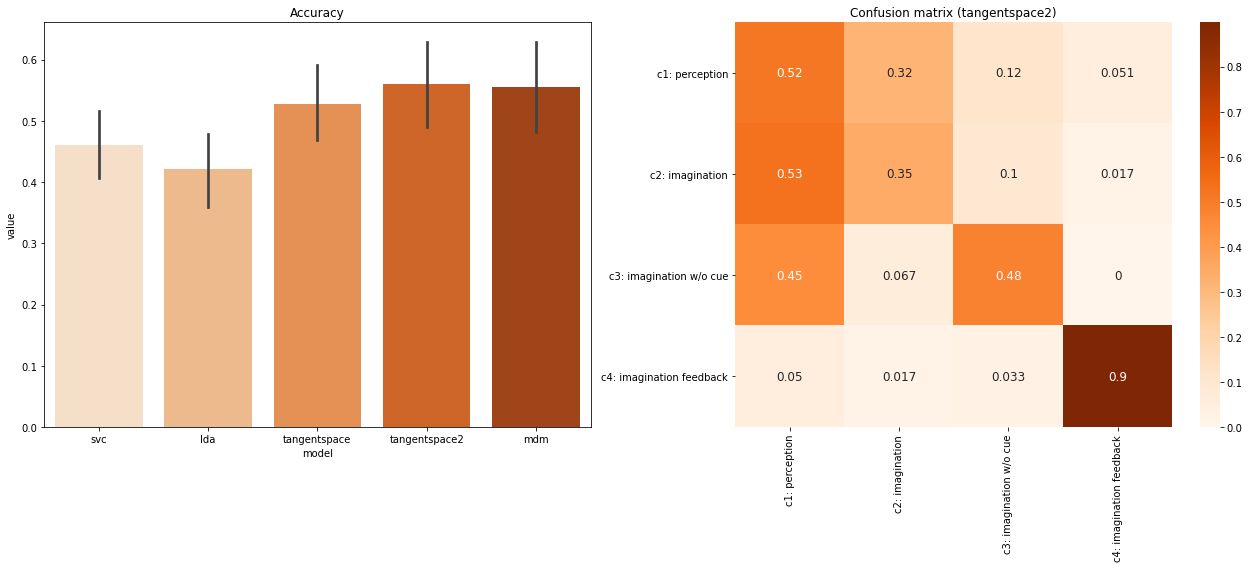

In [26]:
%%capture --no-display

_ = run_pipeline(subjects=['P01'], event_encodings=mapping1, plot=True)

<a id="results2"></a>
### 4.2 Predict Song Groups

In [25]:
# lyrics vs non-lyrics vs instrumental
class0 = [int(f'{g}{s}{c}') for g in [0] for s in SONGS for c in CONDS]
class1 = [int(f'{g}{s}{c}') for g in [1] for s in SONGS for c in CONDS]
class2 = [int(f'{g}{s}{c}') for g in [2] for s in SONGS for c in CONDS]

mapping2 = {}
mapping2.update({event_id: 'g1: lyrics' for event_id in class0})
mapping2.update({event_id: 'g2: non-lyrics' for event_id in class1})
mapping2.update({event_id: 'g3: instrumental' for event_id in class2})

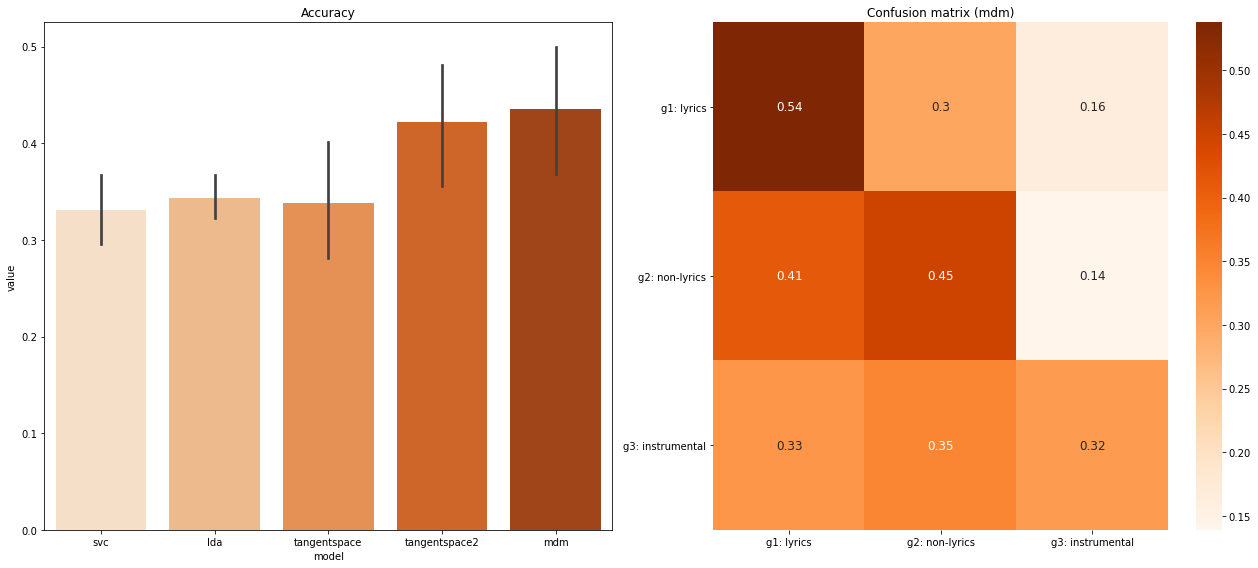

In [28]:
%%capture --no-display

_ = run_pipeline(subjects=['P01'], event_encodings=mapping2, plot=True)

<a id="results3"></a>
### 4.3 Predict All Songs

In [26]:
CONDS_1 = [1, 2, 3]  # here we only select conditions 1-3
mapping3 = {}
mapping3.update({int(f'01{c}'): 's01: Chim Chim Cheree (lyrics)' for c in CONDS_1})
mapping3.update({int(f'02{c}'): 's02: Take Me Out to the Ballgame (lyrics)' for c in CONDS_1})
mapping3.update({int(f'03{c}'): 's03: Jingle Bells (lyrics)' for c in CONDS_1})
mapping3.update({int(f'04{c}'): 's04: Mary Had a Little Lamb (lyrics)' for c in CONDS_1})
mapping3.update({int(f'11{c}'): 's11: Chim Chim Cheree' for c in CONDS_1})
mapping3.update({int(f'12{c}'): 's12: Take Me Out to the Ballgame' for c in CONDS_1})
mapping3.update({int(f'13{c}'): 's13: Jingle Bells' for c in CONDS_1})
mapping3.update({int(f'14{c}'): 's14: Mary Had a Little Lamb' for c in CONDS_1})
mapping3.update({int(f'21{c}'): 's21: Emperor Waltz' for c in CONDS_1})
mapping3.update({int(f'22{c}'): "s22: Hedwig's Theme (Harry Potter)" for c in CONDS_1})
mapping3.update({int(f'23{c}'): 's23: Imperial March (Star Wars Theme)' for c in CONDS_1})
mapping3.update({int(f'24{c}'): 's24: Eine Kleine Nachtmusik' for c in CONDS_1})

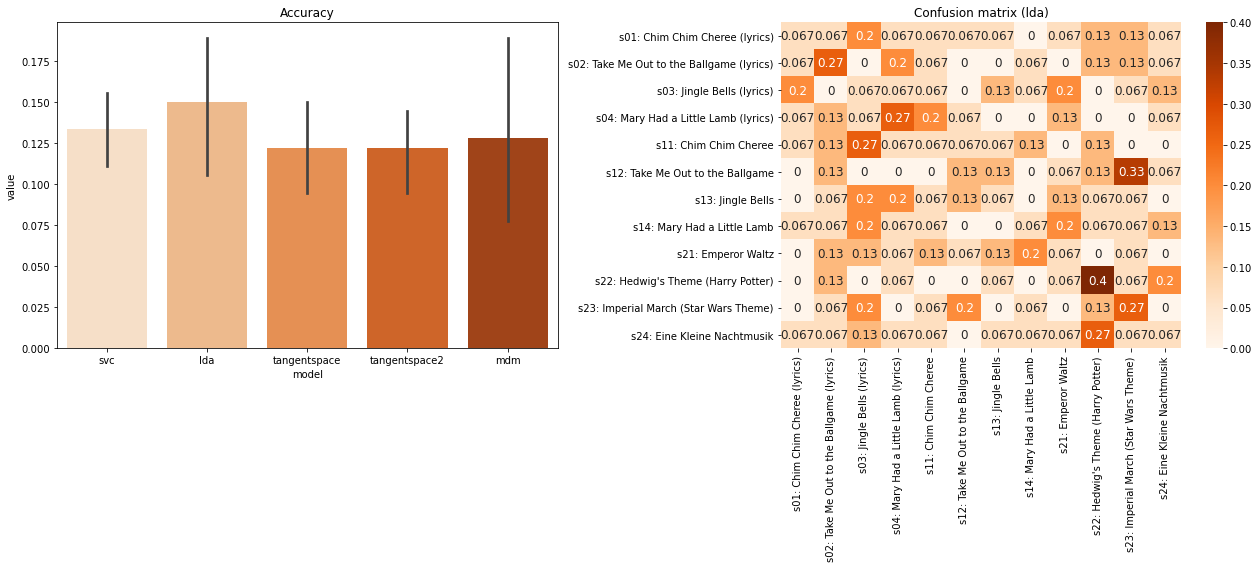

In [30]:
%%capture --no-display

_ = run_pipeline(subjects=['P01'], event_encodings=mapping3, plot=True)

We also tested if we can improve our results by only focus on the lyrics group. Since the brain activity was similar for lyrics and non-lyrics songs, we added all songs from the lyrics and non-lyrics groups together.

In [27]:
mapping4 = {}
mapping4.update({int(f'{g}1{c}'): 's1: Chim Chim Cheree' for g in [0, 1] for c in [1, 2]})
mapping4.update({int(f'{g}2{c}'): 's2: Take Me Out to the Ballgame' for g in [0, 1] for c in [1, 2]})
mapping4.update({int(f'{g}3{c}'): 's3: Jingle Bells' for g in [0, 1] for c in [1, 2]})
mapping4.update({int(f'{g}4{c}'): 's4: Mary Had a Little Lamb' for g in [0, 1] for c in [1, 2]})

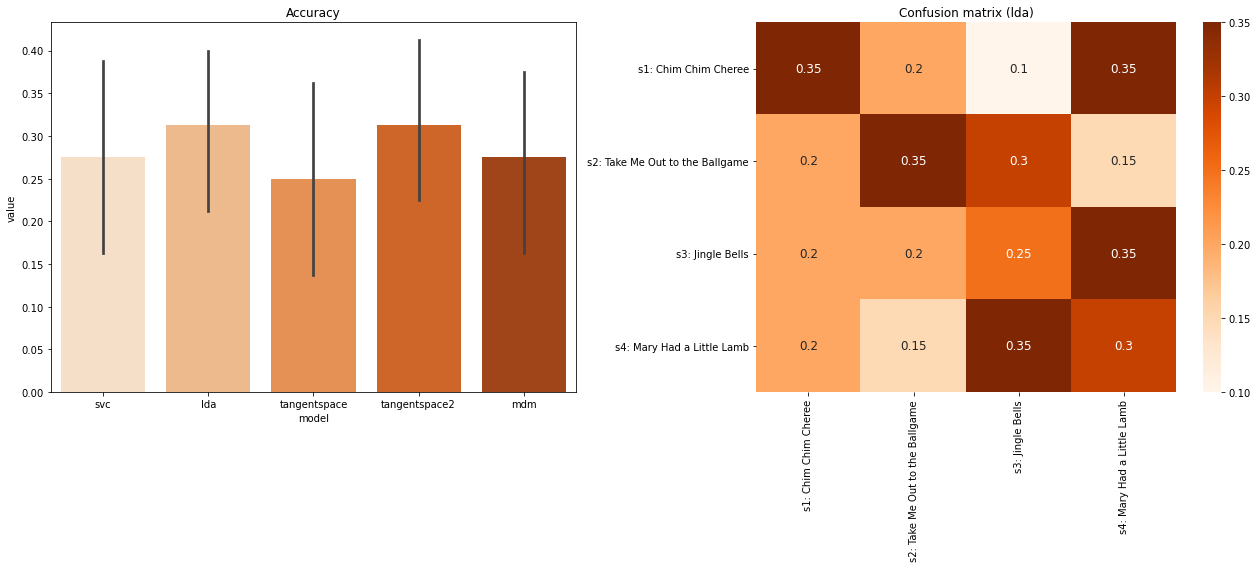

In [32]:
%%capture --no-display

_ = run_pipeline(subjects=['P01'], event_encodings=mapping4, plot=True)

<a id="appendix"></a>
# 5. Appendix

Here we added further experiments using the same code as above. We wanted to give you the option to run our code only using one file, since it takes quite some time to download, preprocess and build models for each participant in this dataset. However, if you want to reproduce the results shown in our presentation, feel free to download all 10 raw `fif` files<sup>4</sup> and uncomment the cells below.


<sub><sup>4</sup>Again, you can download all raw files here: http://bmi.ssc.uwo.ca/OpenMIIR-RawEEG_v1/.</sub>

In [23]:
# %%capture --no-display

# # store preprocessed data for each participant
# store_preprocessed_data()

### 5.1.1 Predict Conditions (All subjects individually)

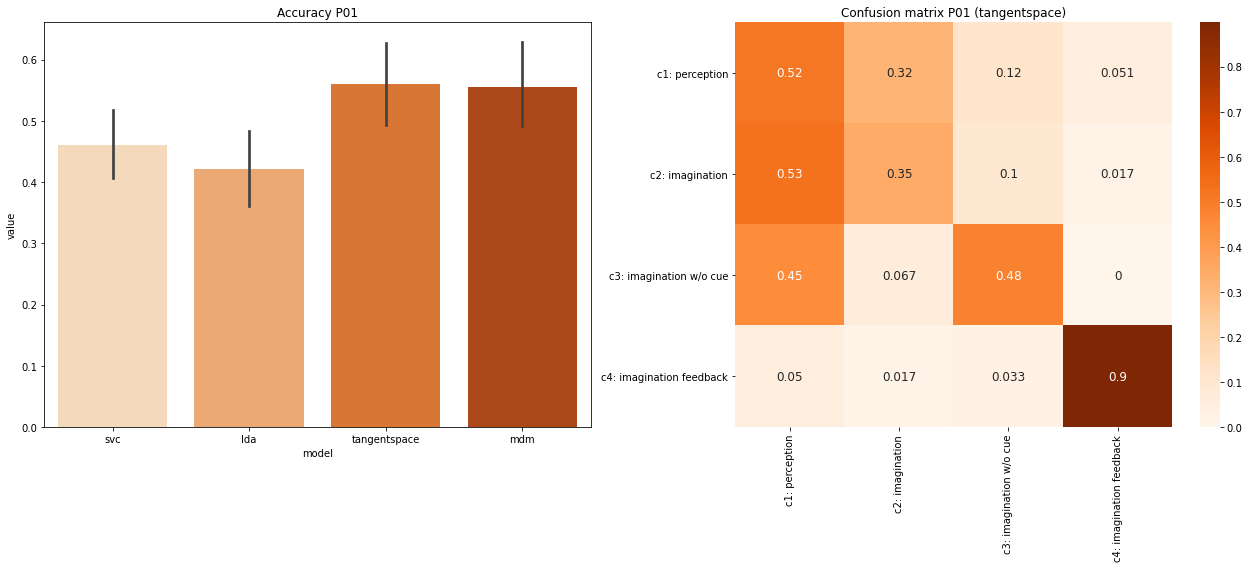

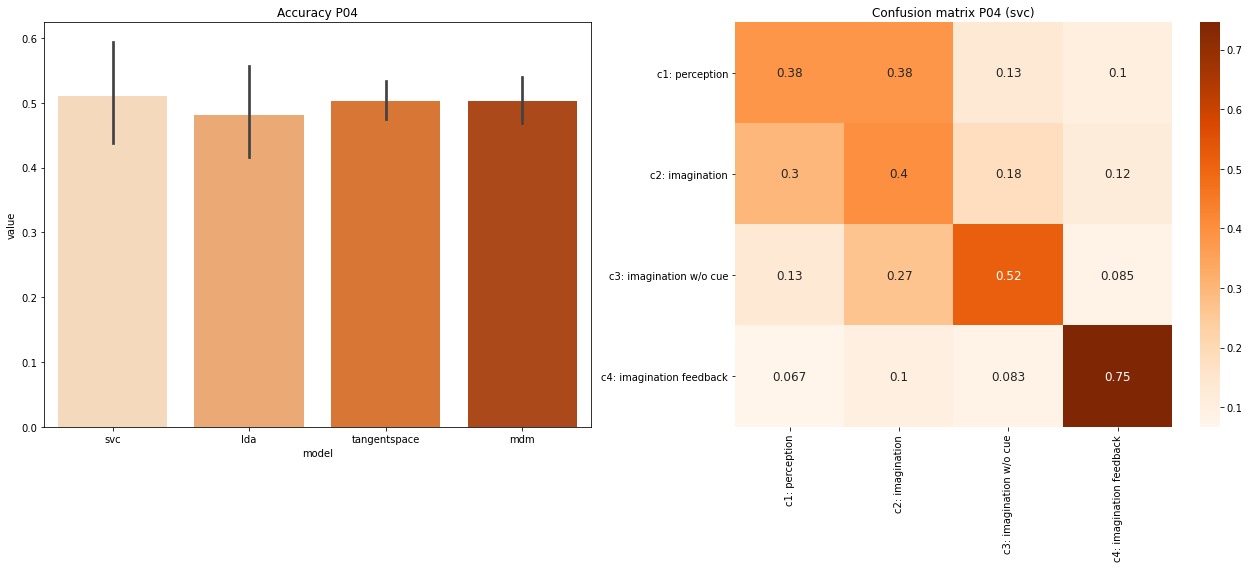

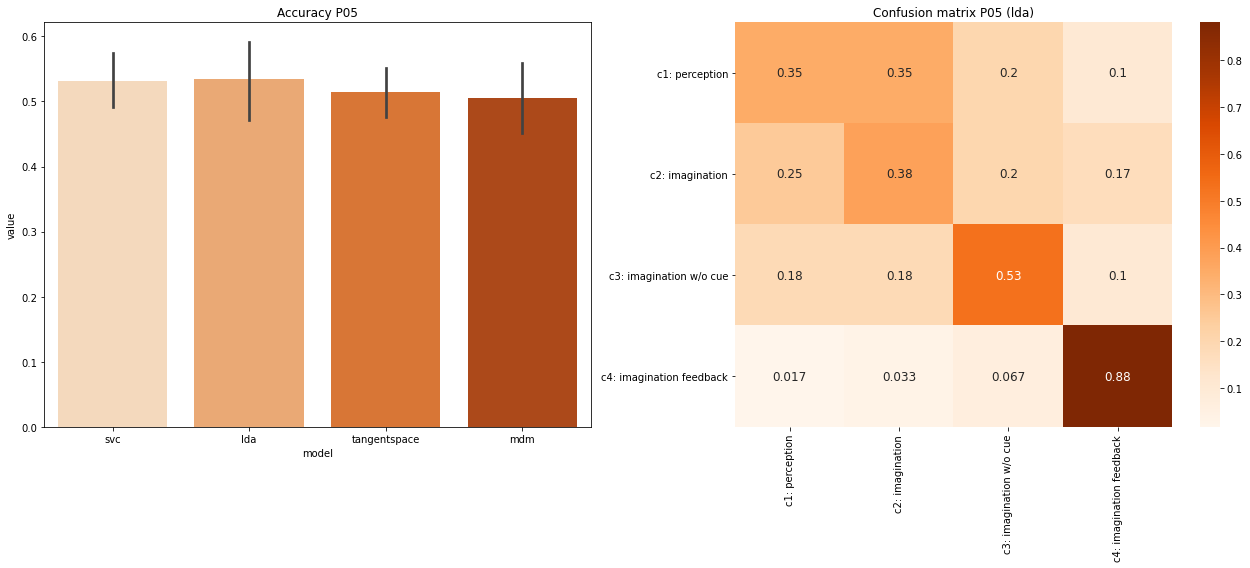

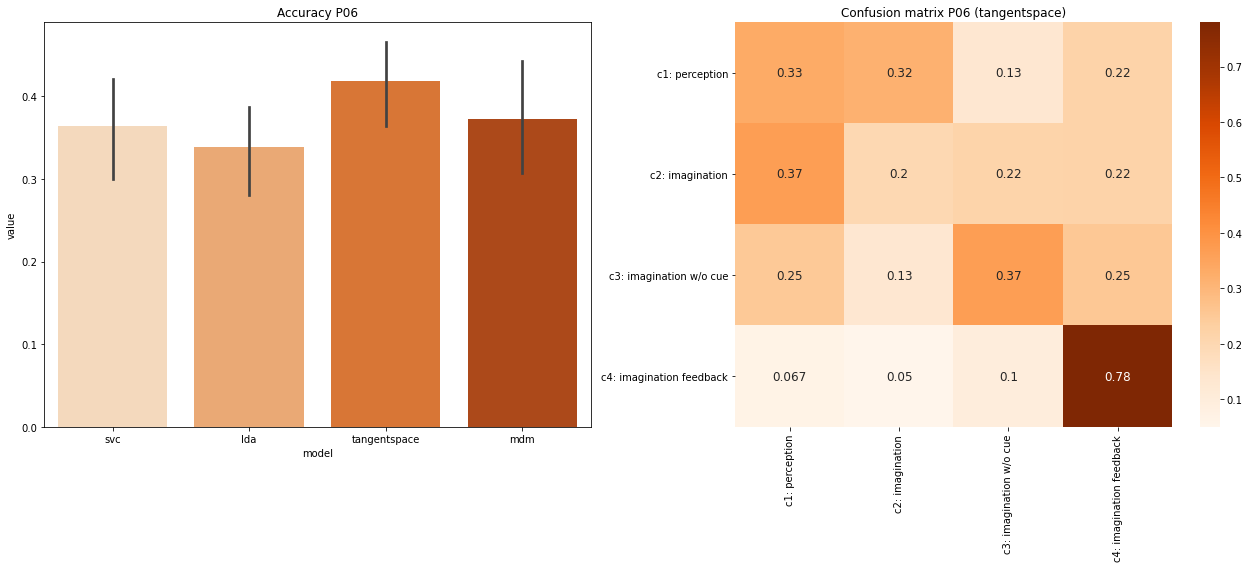

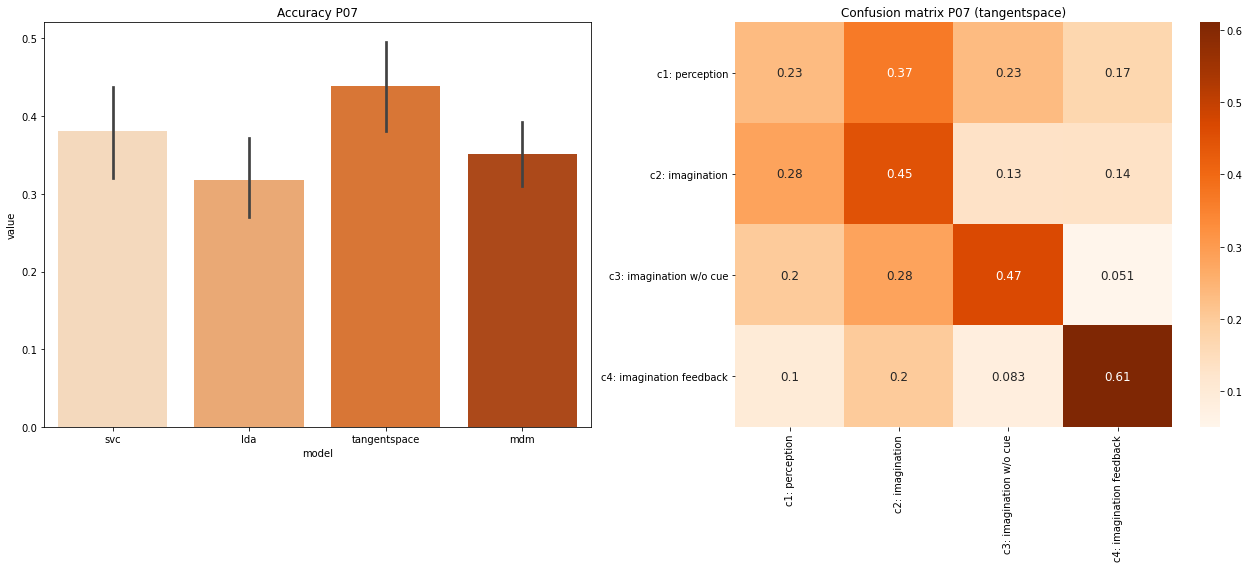

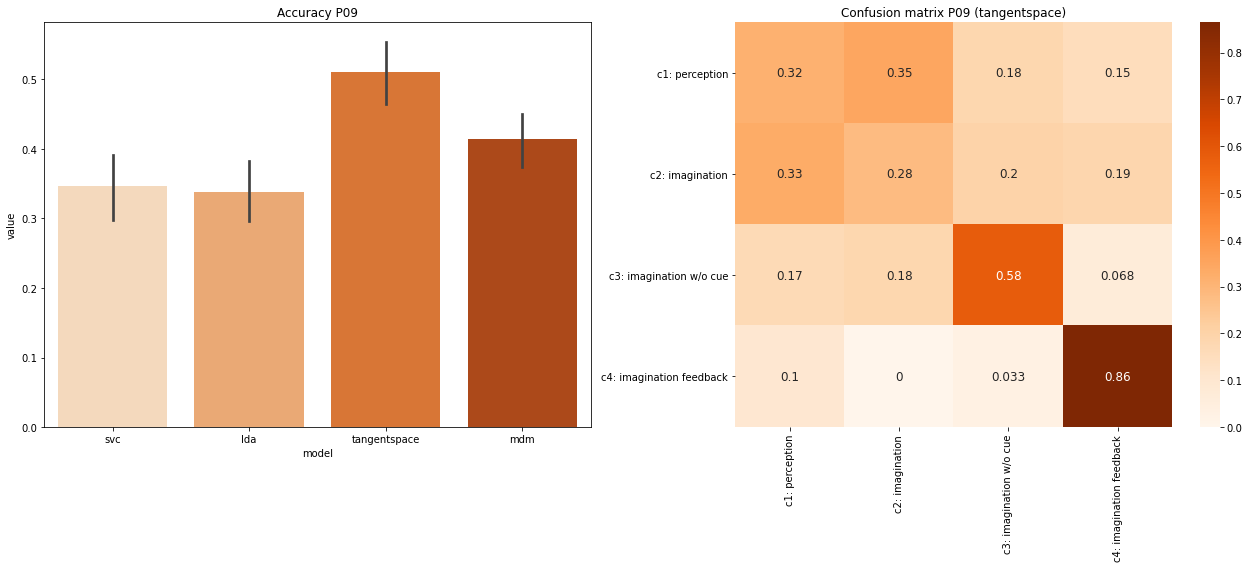

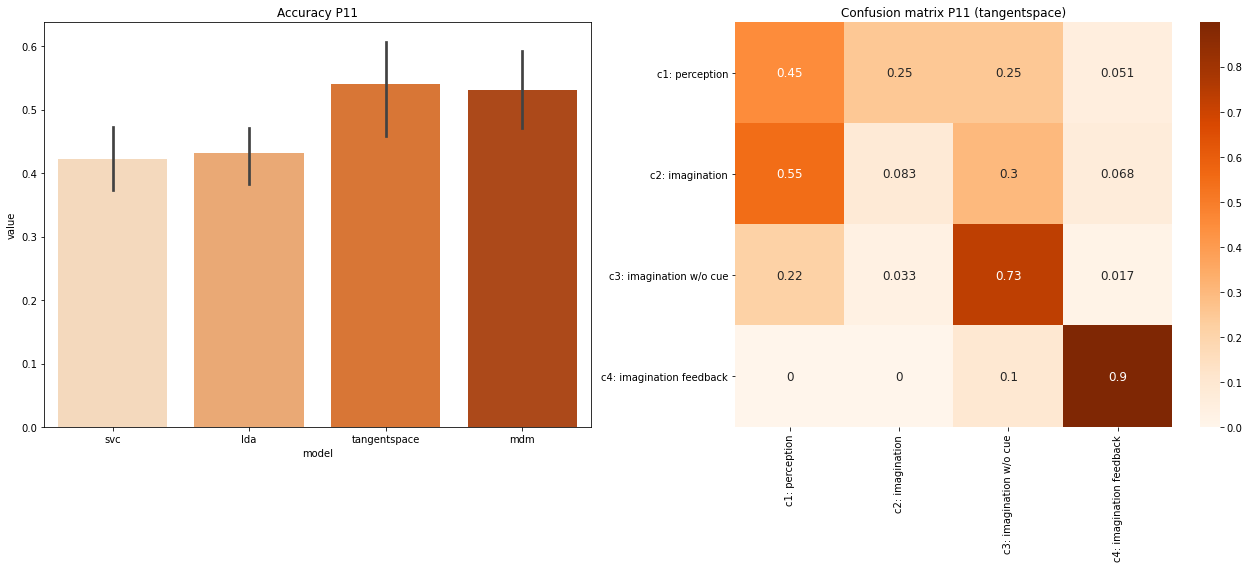

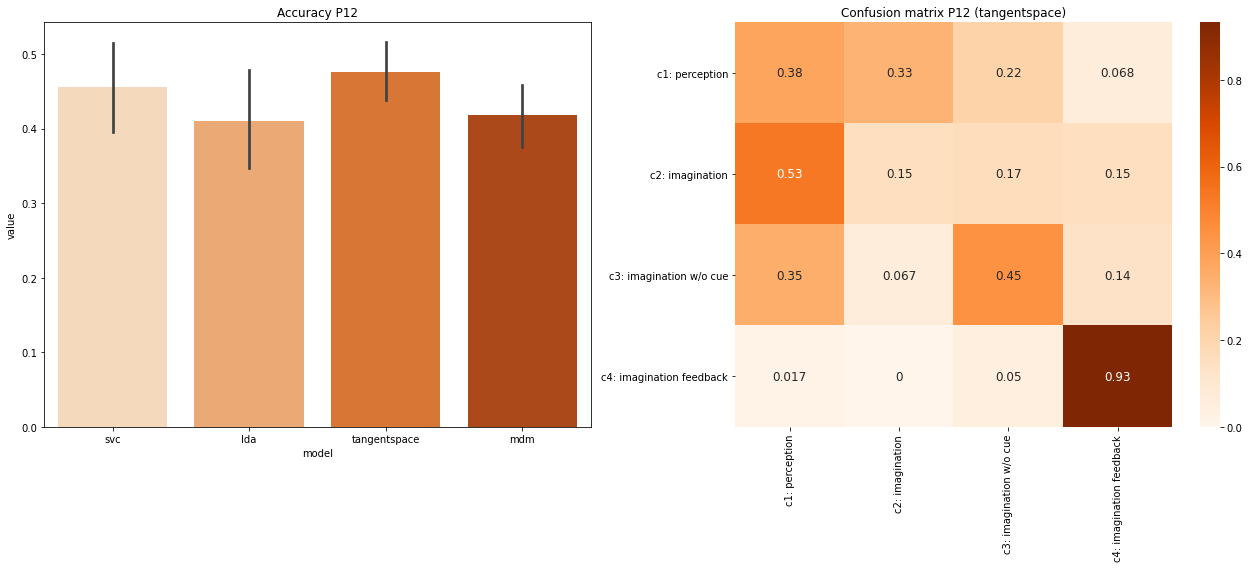

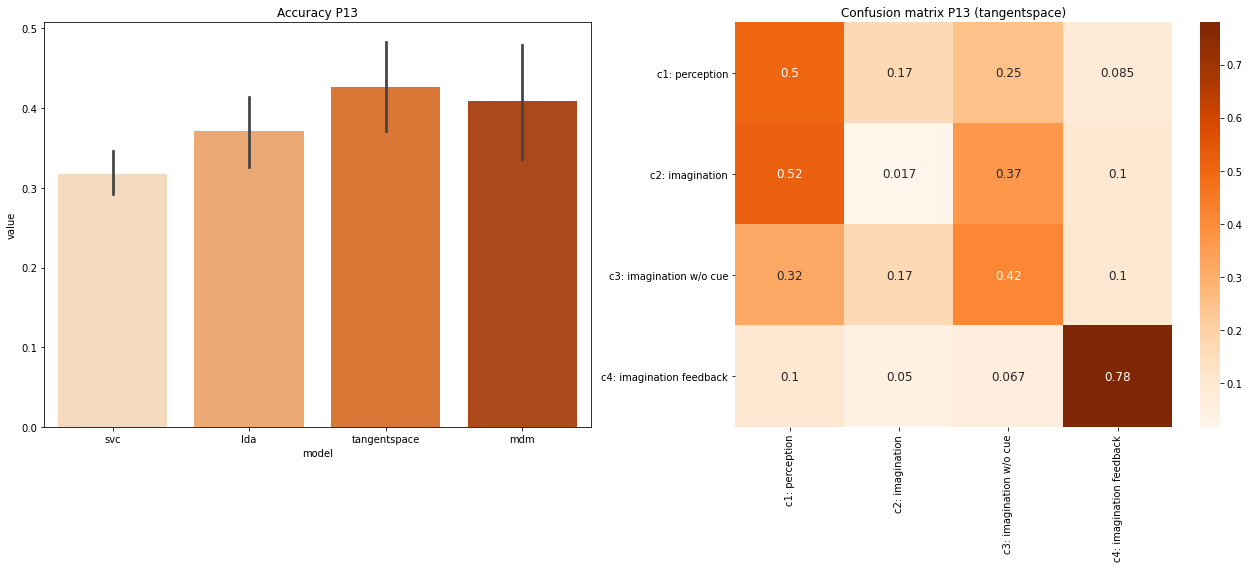

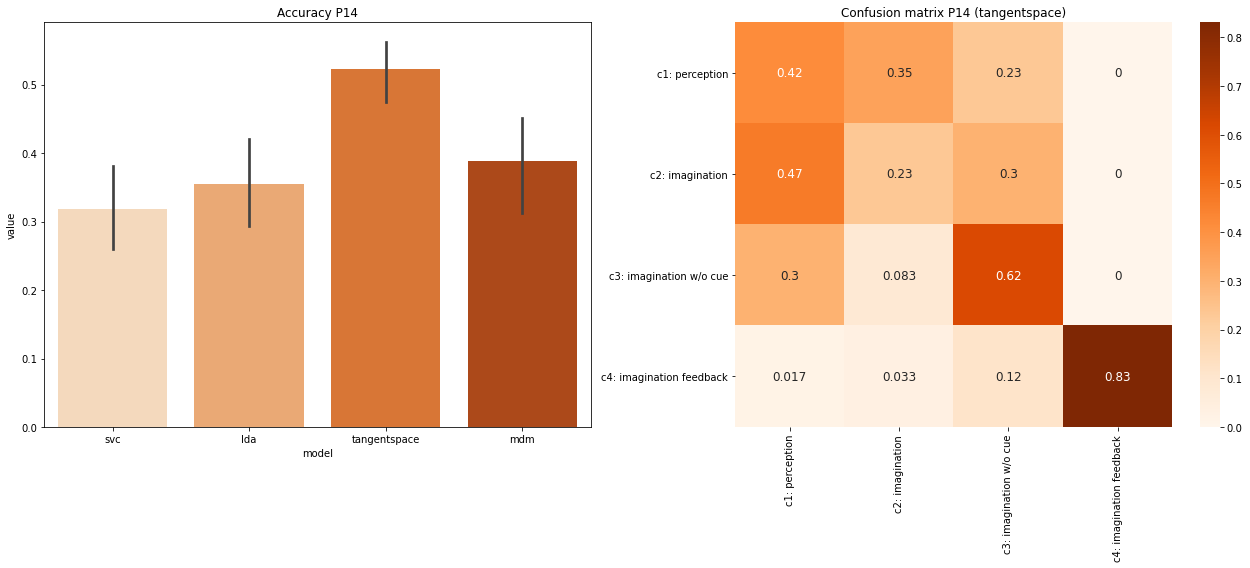

In [60]:
# %%capture --no-display

# accs, cms = [], {}
# subjects = ['P01', 'P04', 'P05', 'P06', 'P07', 'P09', 'P11', 'P12', 'P13', 'P14']
# for subject in subjects:
#     acc, _ = run_pipeline(subjects=[subject], event_encodings=mapping1, plot=True, postfix=subject)
#     accs.append(acc)

### 5.1.2 Predict Conditions (Average Performance)

,svc,lda,tangentspace,mdm
count,10.000000,10.000000,10.000000,10.000000
mean,0.410924,0.400290,0.490978,0.444873
std,0.077179,0.069447,0.048981,0.072173
min,0.317754,0.318478,0.418478,0.351268
25%,0.351178,0.342935,0.448370,0.394158
50%,0.401993,0.391033,0.505978,0.415851
75%,0.459013,0.428895,0.520833,0.504982
max,0.531522,0.535145,0.559964,0.555797


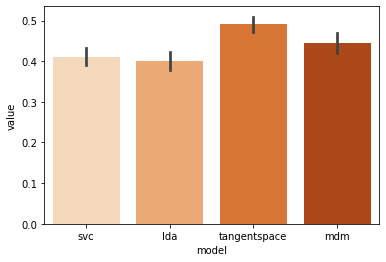

In [89]:
# # average performance plot
# df = pd.melt(pd.concat(pd.DataFrame(acc) for acc in accs)).rename(columns={'variable': 'model'})
# sns.barplot(x=df.model, y=df.value, palette="Oranges")

# # model performance summary
# pd.concat(pd.DataFrame(acc).mean().to_frame().T for acc in accs).describe()

### 5.1.2 Predict Conditions (All subjects together)

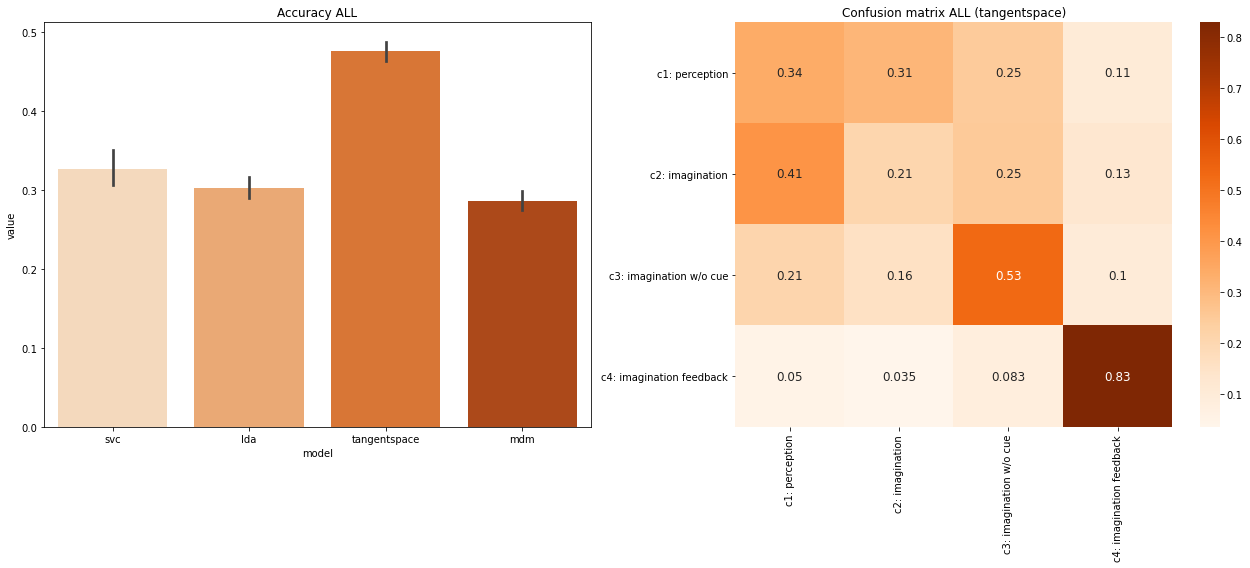

In [90]:
# %%capture --no-display


# acc, _ = run_pipeline(subjects=['P01', 'P04', 'P05', 'P06', 'P07', 'P09', 'P11', 'P12', 'P13', 'P14'], 
#                  event_encodings=mapping1, 
#                  plot=True, 
#                  postfix='ALL')

# pd.DataFrame(acc).describe()

### 5.2 Predict Song Groups (All subjects together)

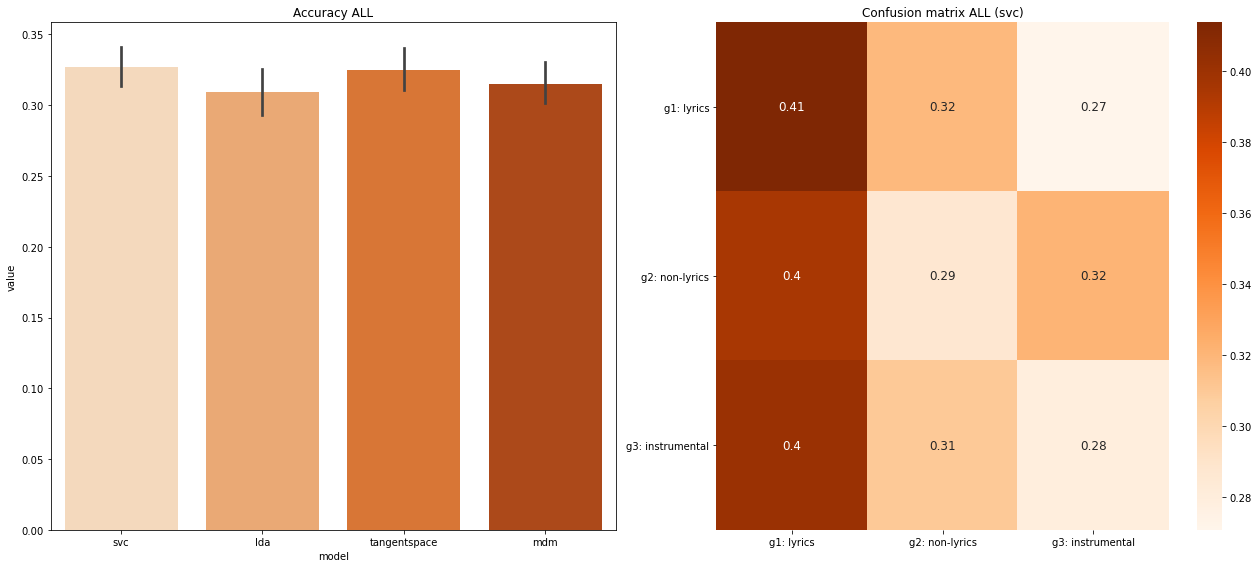

,svc,lda,tangentspace,mdm
count,10.000000,10.000000,10.000000,10.000000
mean,0.327197,0.309623,0.324686,0.315063
std,0.024141,0.028172,0.024572,0.023091
min,0.288703,0.263598,0.297071,0.271967
25%,0.313808,0.289749,0.304393,0.303347
50%,0.324268,0.313808,0.324268,0.313808
75%,0.345188,0.322176,0.332636,0.325314
max,0.364017,0.351464,0.368201,0.355649


In [91]:
%%capture --no-display


acc, _ = run_pipeline(subjects=['P01', 'P04', 'P05', 'P06', 'P07', 'P09', 'P11', 'P12', 'P13', 'P14'], 
                 event_encodings=mapping2, 
                 plot=True, 
                 postfix='ALL')

pd.DataFrame(acc).describe()

### 5.3 Predict Songs (All subjects together)

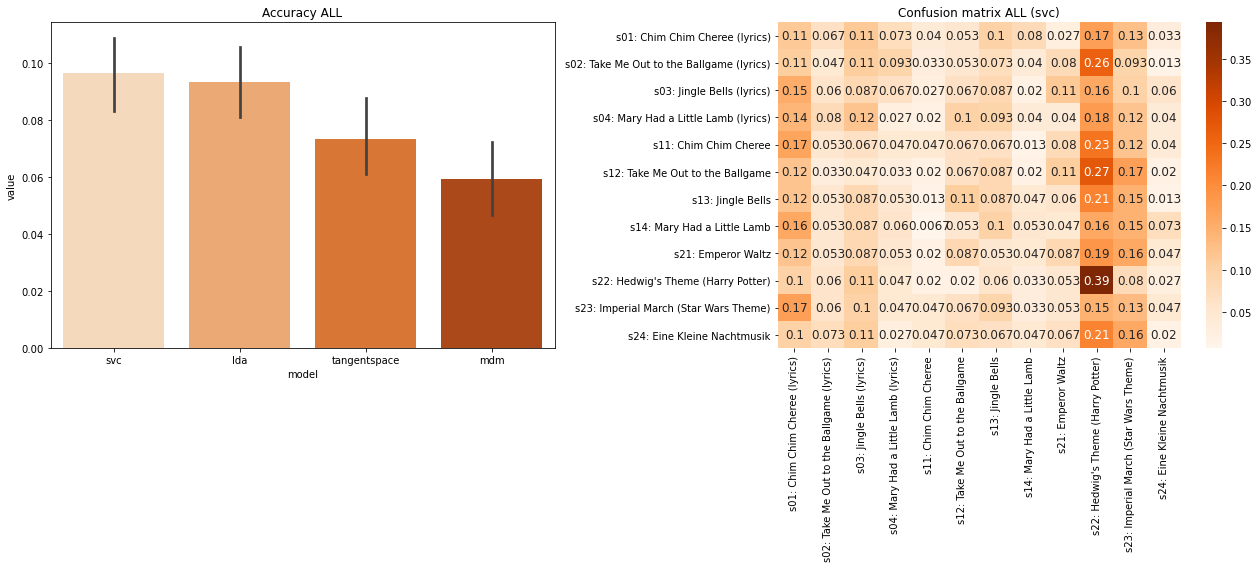

,svc,lda,tangentspace,mdm
count,10.000000,10.000000,10.000000,10.000000
mean,0.096667,0.093333,0.073333,0.059444
std,0.020984,0.020754,0.022498,0.021604
min,0.066667,0.061111,0.044444,0.027778
25%,0.084722,0.077778,0.056944,0.040278
50%,0.094444,0.094444,0.066667,0.058333
75%,0.108333,0.109722,0.088889,0.077778
max,0.133333,0.122222,0.111111,0.088889


In [92]:
%%capture --no-display


acc, _ = run_pipeline(subjects=['P01', 'P04', 'P05', 'P06', 'P07', 'P09', 'P11', 'P12', 'P13', 'P14'], 
                 event_encodings=mapping3, 
                 plot=True, 
                 postfix='ALL')

pd.DataFrame(acc).describe()

<a id="references"></a>
# 6. References

- [1] <a id="bib_github"></a> Machine Learning in Cognitive Science Lab, University of Potsdam, G. Openmiir - public domain dataset of eeg recordings for music imagery information retrieval. https://github.com/sstober/openmiir, 2017.
<br>
- [2] <a id="bib_dataset"></a>Stober, S., Sternin, A., Owen, A. M., and Grahn, J. A. [Towards Music Imagery Information Retrieval: Introducing the OpenMIIR Dataset of EEG Recordings from Music Perception and Imagination](https://www.frontiersin.org/articles/10.3389/fpsyg.2017.01255/full). Conference: Proceedings of the International Conference on Music Information Retrieval (ISMIR) (01 2015), 763–769.
<br>